In [ ]:
# Install libraries
%%capture
!pip install tensorflow-probability
!pip install imageio

In [35]:
# Import General Utilities
import numpy as np
import os
import random
from tqdm.notebook import tqdm, trange
import time
import datetime

#Import tensorflow and its requirements
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
from tensorflow.data.experimental import cardinality as dlen
AUTOTUNE = tf.data.AUTOTUNE

# Import plotting tools and image converters
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import imageio
from IPython import display

# Import file path variable handling
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Constants
batch_size = 32
buffer_size = 500
epochs = 10
img_height = 256
img_width = 256

print(tf.__version__)

2.6.0


In [2]:
# Download OASIS Dataset from the provided link

def download_and_unzip(url, extract_to='.'): # Credit to Antoine Hebert
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)
    http_response.close()

root_dir = '/root/.keras/datasets'
_URL = "https://cloudstor.aarnet.edu.au/plus/s/tByzSZzvvVh0hZA/download"
download_and_unzip(_URL, extract_to=root_dir)
#data_dir = tf.keras.utils.get_file('oasis3', origin=_URL, cache_subdir=root_dir, extract=True)
data_dir = Path(root_dir) / 'keras_png_slices_data'

print(f"Data Directory is {data_dir}")
print(f"Contents: \n\r {os.listdir(data_dir)}")

# Folder Directory Paths
train_dir = data_dir / 'keras_png_slices_train'
train_ans_dir = data_dir / 'keras_png_slices_seg_train'
test_dir = data_dir / 'keras_png_slices_test'
test_ans_dir = data_dir / 'keras_png_slices_seg_test'
val_dir = data_dir / 'keras_png_slices_validate'
val_ans_dir = data_dir / 'keras_png_slices_seg_validate'

Data Directory is /root/.keras/datasets/keras_png_slices_data
Contents: 
 ['keras_png_slices_train', 'keras_png_slices_seg_train', 'keras_png_slices_seg_test', 'keras_png_slices_validate', 'keras_png_slices_seg_validate', 'keras_png_slices_test']


In [38]:
#def count_files(dat_path):
    #return len(list(dat_path.glob('*.*')))

train_ds_list = tf.data.Dataset.list_files(str(train_dir/'*.*'), shuffle=True)
test_ds_list = tf.data.Dataset.list_files(str(test_dir/'*.*'), shuffle=True)
val_ds_list = tf.data.Dataset.list_files(str(val_dir/'*.*'), shuffle=False)

train_ds = train_ds_list.take(dlen(train_ds_list))
test_ds = test_ds_list.take(dlen(test_ds_list))
val_ds = val_ds_list.take(dlen(val_ds_list))

print(f"Train Set is {dlen(train_ds_list)} images, Test Set is {dlen(test_ds_list)} images and Validation Set is {dlen(val_ds_list)} images.")

Train Set is 9664 images, Test Set is 544 images and Validation Set is 1120 images.


In [39]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=1)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    #label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [40]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)
val_ds = configure_for_performance(val_ds)

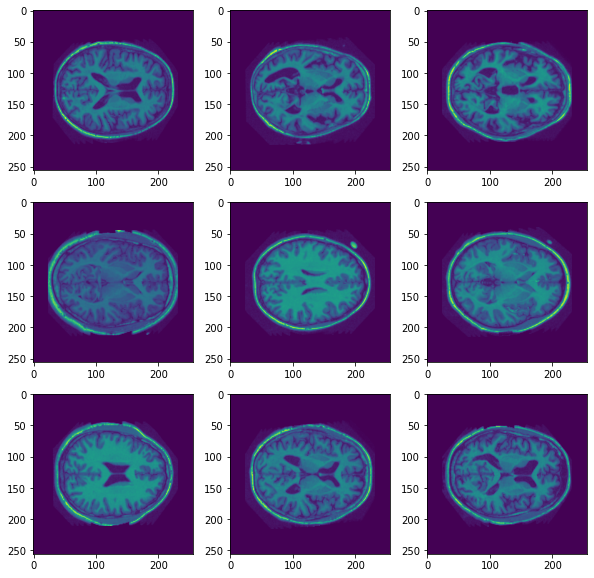

In [41]:
# Show the first scan of 9 patients in the training set
image_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i][:, :, 0])

plt.show()